<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>

# Disaster Risk Monitoring Using Satellite Imagery #

## 02 - Efficient Model Training ##
In this notebook, you will learn how to train a segmentation model with the TAO Toolkit using pre-trained ResNet-18 weights. In addition, you will learn how to export the model for deployment. 

**Table of Contents**
<br>
This notebook covers the below sections: 
1. [Introduction to the TAO Toolkit](#s2-1)
    * [Transfer Learning](#s2-1.1)
    * [Vision AI Pre-Trained Models Supported](#s2-1.2)
    * [TAO Toolkit Workflow](#s2-1.3)
    * [TAO Launcher, CLI (Command Line Interface), and Spec Files](#s2-1.4)
    * [Set Up Environment Variables](#s2-1.5)
    * [Exercise #1 - Explore TAO Toolkit CLI](#s2-e1)
2. [U-Net Semantic Segmentation Model](#s2-2)
    * [Preparation for Model Training](#s2-2.1)
    * [Download Pre-Trained Model](#s2-2.2)
    * [Prepare Dataset](#s2-2.3)
    * [Model Training](#s2-2.4)
    * [Exercise #2 - Modify Dataset Config](#s2-e2)
    * [Exercise #3 - Modify Model Config](#s2-e3)
    * [Exercise #4 - Modify Training Config](#s2-e4)
    * [Combine Configuration Files](#s2-2.5)
    * [Initiate Model Training](#s2-2.6)
    * [Evaluating the Model](#s2-2.7)
    * [Visualizing Model Inference](#s2-2.8)
3. [Model Export](#s2-3)
    * [TensorRT - Programmable Inference Accelerator](#s2-3.1)
    * [Export the Trained Model](#s2-3.2)

<a name='s2-1'></a>
## Introduction to the TAO Toolkit ##
The TAO Toolkit, Train Adapt Optimize, is a framework that simplifies the AI/ML model development workflow. It lets developers fine-tune pre-trained models with custom data to produce highly accurate computer vision models efficiently, eliminating the need for large training runs and deep AI expertise. In addition, it also enables model optimization for inference performance. You can learn more about the TAO Toolkit [here](https://developer.nvidia.com/tao-toolkit) or read the documentation [here](https://docs.nvidia.com/tao/tao-toolkit/index.html#).
<p><img src="images/tao_toolkit.png" width=720></p>

The TAO Toolkit uses pre-trained models to accelerate the AI development process and reduce costs associated with large scale data collection, labeling, and training models from scratch. Transfer learning with pre-trained models can be used for classification, object detection, and image segmentation tasks. The TAO Toolkit offers useful features such as:
* Low-coding approach that requires no AI framework expertise, reducing the barrier of entry for anyone who wants to get started building AI-based applications
* Flexible configurations that allow customization to help advance users prototype faster
* Large catalogue of production-ready pre-trained models for common Computer Vision (CV) tasks that can also be customized with users' own data
* Easy to use interface for model optimization such as pruning and quantization-aware training
* Integration with the Triton Inference Server

_Note: The TAO Toolkit comes with a set of reference scripts and configuration specifications with default parameter values that enable developers to kick-start training and fine-tuning. This lowers the bar and enables users without a deep understanding of models, expertise in deep learning, or beginning coding skills to be able to train new models and fine-tune the pre-trained ones._

<a name='s2-1.1'></a>
### Transfer Learning ###
In practice, it is rare and inefficient to initiate the learning task on a network with randomly initialized weights due to factors like data scarcity (inadequate number of training samples) or prolonged training times. One of the most common techniques to overcome this is to use transfer learning. Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where developers use a model trained on one task and re-train to use it on a different task. This works surprisingly well as many of the early layers in a neural network are the same for similar tasks. For example, many of the early layers in a convolutional neural network used for a CV model are primarily used to identify outlines, curves, and other features in an image. The network formed by these layers are referred to as the **backbone** of a more complex model. Also known as feature extractors, they take as input the image and extracts the feature map upon which the rest of the network is based. The learned features from these layers can be applied to similar tasks carrying out the same identification in other domains. Transfer learning enables adaptation (fine-tuning) of an existing neural network to a new one, which requires significantly less domain-specific data. In most cases, fine-tuning takes significantly less time (a reduction by x10 factor is common), saving time and resources. As it relates to vision AI, transfer learning can be used for adding new classification by transferring weights from one application to another.

<p><img src='images/transfer_learning.png' width=720></p>

More information about transfer learning can be found in this [blog](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/).

<a name='s2-1.2'></a>
### Vision AI Pre-Trained Models Supported ###
Developers, system builders, and software partners building disaster risk monitoring systems can bring their own custom data to train with and fine-tune pre-trained models quickly instead of going through significant effort in large data collection and training from scratch. **General purpose vision models** provide pre-trained weights for popular network architectures to train an image classification model, an object detection model, or a segmentation model. This gives users the flexibility and control to build AI models for any number of applications, from smaller lightweight models for edge deployment to larger models for more complex tasks. They are trained on the [Open Images](https://opensource.google/projects/open-images-dataset) dataset and provide a much better starting point for training versus training from scratch or starting from random weights. 

The TAO Toolkit adapts popular network architectures and backbones to custom data, allowing developers to train, fine tune, prune, and export highly optimized and accurate AI models. When working with TAO, first choose the model architecture to be built, then choose one of the supported backbones. 
<p><img src='images/openimage_table.jpg' width=720></p>

_Note: The pre-trained weights from each feature extraction network merely act as a starting point and may not be used without re-training. In addition, the pre-trained weights are network specific and shouldn't be shared across models that use different architectures._

<a name='s2-1.3'></a>
### TAO Toolkit Workflow ###
Building disaster risk monitoring systems is hard, and tailoring even a single component to the needs of the enterprise for deployment is even harder. Deployment for a domain-specific application typically requires several cycles of re-training, fine-tuning, and deploying the model until it satisfies the requirements. As a starting point, training typically follows the below steps: 

0. Configuration
1. Download a pre-trained model from NGC
2. Prepare the data for training
3. Train the model using transfer learning
4. Evaluate the model for target predictions
5. Export the model
* Steps to optimize the model for improved inference performance

<p><img src='images/tao_toolkit_workflow.png' width=720></p>

<a name='s2-1.4'></a>
### TAO Launcher, CLI (Command Line Interface), and Spec Files ###
The TAO Toolkit is a low-coding framework that makes it easy to get started. It uses a **launcher** to pull from NGC registry and instantiate the appropriate TAO [container](https://www.docker.com/resources/what-container/) that performs the desired subtasks such as convert data, train, evaluate, or export. The TAO launcher is a python package distributed as a python wheel listed in the `nvidia-pyindex` python index, which has been prepared for you already. 

Users interact with the launcher with its **Command Line Interface** that is configured using simple [**Protocol Buffer**](https://developers.google.com/protocol-buffers) **specification files** to include parameters such as the dataset parameters, model parameters, and optimizer and training hyperparameters. More information about the TAO Toolkit Launcher can be found in the [TAO Docs](https://docs.nvidia.com/tao/tao-toolkit/text/tao_launcher.html#tao-launcher). 

The tasks can be invoked from the TAO Toolkit Launcher using the convention `tao <task> <subtask> <args_per_subtask>`, where `<args_per_subtask>` are the arguments required for a given subtask. Once the container is launched, the subtasks are run by the TAO Toolkit containers using the appropriate hardware resources. 
<p><img src='images/tao_launcher.gif' width=720></p>

<p><img src='images/important.png' width=720></p>
Since the TAO Toolkit uses the launcher to pull containers, the first time running a task may take extra time to load.

<a name='s2-1.5'></a>
### Set Up Environment Variables ###
We set up a couple of environment variables to help us mount the local directories to the tao container. Specifically, we want to set paths for the `$LOCAL_TRAINING_DATA`, `$LOCAL_SPEC_DIR`, and `$LOCAL_PROJECT_DIR` for the output of the TAO experiment with their respective paths in the TAO container. In doing so, we can make sure that the TAO experiment generated collaterals such as checkpoints, model files (e.g. `.tlt` or `.etlt`), and logs are output to `$LOCAL_PROJECT_DIR/unet`. 

_Note that users will be able to define their own export encryption key when training from a general-purpose model. This is to protect proprietary IP and used to decrypt the `.etlt` model during deployment._

In [1]:
# DO NOT CHANGE THIS CELL
# set environment variables
import os
import json

%set_env KEY=my_model_key

%set_env LOCAL_PROJECT_DIR=/dli/task/tao_project
%set_env LOCAL_DATA_DIR=/dli/task/flood_data
%set_env LOCAL_SPECS_DIR=/dli/task/tao_project/spec_files
os.environ["LOCAL_EXPERIMENT_DIR"]=os.path.join(os.getenv("LOCAL_PROJECT_DIR"), "unet")

%set_env TAO_PROJECT_DIR=/workspace/tao-experiments
%set_env TAO_DATA_DIR=/workspace/tao-experiments/data
%set_env TAO_SPECS_DIR=/workspace/tao-experiments/spec_files
%set_env TAO_EXPERIMENT_DIR=/workspace/tao-experiments/unet

!mkdir $LOCAL_EXPERIMENT_DIR

env: KEY=my_model_key
env: LOCAL_PROJECT_DIR=/dli/task/tao_project
env: LOCAL_DATA_DIR=/dli/task/flood_data
env: LOCAL_SPECS_DIR=/dli/task/tao_project/spec_files
env: TAO_PROJECT_DIR=/workspace/tao-experiments
env: TAO_DATA_DIR=/workspace/tao-experiments/data
env: TAO_SPECS_DIR=/workspace/tao-experiments/spec_files
env: TAO_EXPERIMENT_DIR=/workspace/tao-experiments/unet
mkdir: cannot create directory ‘/dli/task/tao_project/unet’: File exists


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from in and out of the docker. This is done by creating a `.tao_mounts.json` file. For more information, please refer to the [launcher instance](https://docs.nvidia.com/tao/tao-toolkit/tao_launcher.html) in the user guide. Setting the `DockerOptions` ensures that you don't have permission issues when writing data into folders created by the TAO docker.

In [2]:
# DO NOT CHANGE THIS CELL
# mapping up the local directories to the TAO docker
mounts_file = os.path.expanduser("~/.tao_mounts.json")

drive_map = {
    "Mounts": [
            # Mapping the data directory
            {
                "source": os.environ["LOCAL_PROJECT_DIR"],
                "destination": "/workspace/tao-experiments"
            },
            # Mapping the specs directory.
            {
                "source": os.environ["LOCAL_SPECS_DIR"],
                "destination": os.environ["TAO_SPECS_DIR"]
            },
            # Mapping the data directory.
            {
                "source": os.environ["LOCAL_DATA_DIR"],
                "destination": os.environ["TAO_DATA_DIR"]
            },
        ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}

# writing the mounts file
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

To see the usage of different functionality that are supported, use the `-h` or `--help` option. For more information, see the [TAO Toolkit Quick Start Guide](https://docs.nvidia.com/tao/tao-toolkit/text/tao_toolkit_quick_start_guide.html). 
Here is the **sample output**: 

In [3]:
# DO NOT CHANGE THIS CELL
!tao --help

usage: tao [-h]
           {list,stop,info,action_recognition,augment,bpnet,classification,converter,detectnet_v2,dssd,efficientdet,emotionnet,faster_rcnn,fpenet,gazenet,gesturenet,heartratenet,intent_slot_classification,lprnet,mask_rcnn,multitask_classification,n_gram,punctuation_and_capitalization,question_answering,retinanet,spectro_gen,speech_to_text,speech_to_text_citrinet,ssd,text_classification,token_classification,unet,vocoder,yolo_v3,yolo_v4,yolo_v4_tiny}
           ...

Launcher for TAO Toolkit.

optional arguments:
  -h, --help            show this help message and exit

tasks:
  {list,stop,info,action_recognition,augment,bpnet,classification,converter,detectnet_v2,dssd,efficientdet,emotionnet,faster_rcnn,fpenet,gazenet,gesturenet,heartratenet,intent_slot_classification,lprnet,mask_rcnn,multitask_classification,n_gram,punctuation_and_capitalization,question_answering,retinanet,spectro_gen,speech_to_text,speech_to_text_citrinet,ssd,text_classification,token_classification,une

With the TAO Toolkit, users can train models for object detection, classification, segmentation, optical character recognition, facial landmark estimation, gaze estimation, and more. In TAO's terminology, these would be the **tasks**, which support **subtasks** such as `train`, `prune`, `evaluate`, `export`, etc. Each task/subtask requires different combinations of configuration files to accommodate for different parameters, such as the dataset parameters, model parameters, and optimizer and training hyperparameters. Part of what makes TAO Toolkit so easy to use is that most of those parameters are hidden away in the form of experiment specification files (spec files). They are detailed in the [documentation](https://docs.nvidia.com/tao/tao-toolkit/#tao-toolkit) for reference. It's very helpful to have these resources handy when working with the TAO Toolkit. In addition, there are several specific tasks that help with handling the launched commands. 

Below are the tasks available in the TAO Toolkit, organized by their respective computer vision objectives. We grayed out the tasks for Conversational AI as they are out of scope for this course.

<img src='images/tao_tasks.png' width=740>

<a name='s2-e1'></a>
### Exercise #1 - Explore TAO Toolkit CLI ###
Let's explore some TAO Toolkit tasks. 

**Instructions**:<br>
* Modify the `<FIXME>`s only and execute the cell, choosing a task from options such as: `[classification, detectnet_v2, mask_rcnn, emotionnet, etc.]`, followed by a subtask from options such as: `[calibration_tensorfile, dataset_convert, evaluate, export, inference, prune, train]`. 

In [4]:
# Example: !tao unet train --help
!tao <<<<detectnet_v2>>>> <<<<trainE>>>> --help

/bin/bash: -c: line 0: syntax error near unexpected token `<'
/bin/bash: -c: line 0: `tao <<<<detectnet_v2>>>> <<<<trainE>>>> --help'


Click ... to show **solution**. 

<p><img src='images/check.png' width=720></p>

Did you get the below error message? This is likely due to a bad NGC configuration. Please check the NGC CLI and Docker Registry section of the [introduction notebook](00_introduction.ipynb).

<a name='s2-2'></a>
## U-Net Semantic Segmentation Model ##
[U-Net](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/pretrained_semantic_segmentation) is a neural network for image segmentation. This is the type of task we want to perform for our disaster risk monitoring system in order to label each pixel as either `flood` or `notflood`. With the TAO Toolkit, we can choose the desired ResNet-18 backbone as a feature extractor. As such, we will use the `unet` task, which supports the following subtasks: 
* `train`
* `evaluate`
* `inference`
* `prune`
* `export`

<p><img src='images/rewind.png' width=720><p>
    
These subtasks can be invoked using the convention `tao unet <subtask> <args_per_subtask>` on the command-line, where `args_per_subtask` are the arguments required for a given subtask. Additionally, we can always find more information about these subtasks with `tao unet <subtask> -h` or `tao unet <subtask> --help`. 

<a name='s2-2.1'></a>
### Preparation for Model Training ###
For the remaining of the notebook, we will use the TAO Toolkit to train a semantic segmentation model. Below is what the model development workflow looks like. We start by preparing a pre-trained model and the data. Next, we prepare the configuration file(s) and begin to train the model with new data and evaluate its performance. We will export the model once its satisfactory. Note that this notebook does not include inference optimization steps, which is important for disaster risk monitoring systems that are deployed on edge devices. 
<p><img src='images/simple_workflow.png' width=720></p>

<a name='s2-2.2'></a>
### Download Pre-Trained Model ###
Developers typically begin by choosing and downloading a pre-trained model from [NGC](https://ngc.nvidia.com/), which contains pre-trained weights of the architecture of their choice. It's difficult to immediately identify which model/architecture will work best for a specific use case as there is often a tradeoff between time to train, accuracy, and inference performance. It is common to compare across multiple models before picking the best candidate.

Here are some pointers that will help choose an appropriate model: 
* Look at the model inputs/outputs to decide if it will fit your use case. 
* Input format is also an important consideration. For example, some models expect the input to be 0-1 normalized with input channels in RGB order. Some models that use a different input order may require input preprocessing/mean subtraction that might result in suboptimal performance. 

We can use the `ngc registry model list <model_glob_string>` command to get a list of models that are hosted on the NGC model registry. For example, we can use `ngc registry model list nvidia/tao/*` to list all available models. The `--column` option identifies the columns of interest. More information about the NGC Registry CLI can be found in the [User Guide](https://docs.nvidia.com/dgx/pdf/ngc-registry-cli-user-guide.pdf). `The ngc registry model download-version <org>/[<team>/]<model-name:version>` command will download the model from the registry. It has a `--dest` option to specify the path to download directory. Alternatively, a catalog of support models can also be found [here](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/collections/tao_computervision).

In [5]:
# DO NOT CHANGE THIS CELL
# list all available models
!ngc registry model list nvidia/tao/pretrained_semantic_segmentation:*

[{
    "accuracyReached": 77.56,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T13:43:25.180Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "153.7169",
    "numberOfEpochs": 80,
    "status": "UPLOAD_COMPLETE",
    "totalFileCount": 1,
    "totalSizeInBytes": 161183816,
    "versionId": "vgg19"
},{
    "accuracyReached": 82.2,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T13:43:56.685Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "515.0932",
    "numberOfEpochs": 80,
    "status": "UPLOAD_COMPLETE",
    "totalFileCount": 1,
    "totalSizeInBytes": 540114376,
    "versionId": "vgg16"
},{
    "accuracyReached": 77.91,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T13:44:52.409Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "294.1976",
    "numberO

<p><img src='images/check.png' width=720></p>

Did you get the below error message? This is likely due to a bad NGC CLI configuration. Please check the NGC CLI and Docker Registry section of the [introduction notebook](00_introduction.ipynb).

In [6]:
# DO NOT CHANGE THIS CELL
# create directory to store the pre-trained model
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

# download the pre-trained segmentation model from NGC
!ngc registry model download-version nvidia/tao/pretrained_semantic_segmentation:resnet18 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18 

{
    "download_end": "2023-09-24 16:33:33.456390",
    "download_start": "2023-09-24 16:33:30.452243",
    "download_time": "3s",
    "files_downloaded": 1,
    "local_path": "/dli/task/tao_project/unet/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18",
    "size_downloaded": "82.38 MB",
    "status": "Completed",
    "transfer_id": "pretrained_semantic_segmentation_vresnet18"
}


For this lab, we will use _ResNet18_ as the architecture for the semantic segmentation model. [Residual neural network](https://en.wikipedia.org/wiki/Residual_neural_network), or **ResNet**, is a type of convolutional neural network used as a backbone for many computer vision tasks. The `18` refers to the number of layers in this architecture. It should be noted that typically the deeper (i.e. more layers) a neural network is, the more time consuming it is to compute.

<p><img src='images/tip.png' width=720></p>

We designated the model to be downloaded locally to `tao_project/unet/pretrained_resnet18`, which is mapped to `/workspace/tao-experiments/unet/pretrained_resnet18` in the TAO container based on the mapping of `LOCAL_PROJECT_DIR` to `TAO_PROJECT_DIR`. Looking at the `local_path` and `transfer_id` keys of the output JSON, we can gather that the path of the pre-trained model should be in the `tao_project/unet/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18 directory`. When referencing paths for the TAO Toolkit, it's important to use paths based on the TAO container. In this case it would be `/workspace/tao-experiments/unet/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18`.

In [7]:
# DO NOT CHANGE THIS CELL
!tree -a tao_project/unet/pretrained_resnet18

tao_project/unet/pretrained_resnet18
└── pretrained_semantic_segmentation_vresnet18
    └── resnet_18.hdf5

1 directory, 1 file


<a name='s2-2.3'></a>
### Prepare Dataset ###
The TAO Toolkit expects the training data for the `unet` subtasks to be in the format described in the [documentation](https://docs.nvidia.com/tao/tao-toolkit/text/data_annotation_format.html#id8). Each mask image is a single-channel image, where every pixel is assigned an integer value that represents the segmentation class `label_id`, as per the mapping provided in the `dataset_config`. Additionally, each image and label have the same file ID before the extension and size. The image-to-label correspondence is maintained using this filename. The data folder structure for images and masks must be in the following format. 
<p><img src='images/semantic_segmentation_input.PNG' width=720></p>

_The `test` folder in the above directory structure is optional; any folder can be used for inference._

Below we will split the data into `train` set and `validation` set and copy the images into their respective folder.

In [8]:
# DO NOT CHANGE THIS CELL
# remove existing splits
!rm -rf $LOCAL_DATA_DIR/images/train
!mkdir -p $LOCAL_DATA_DIR/images/train
!rm -rf $LOCAL_DATA_DIR/images/val
!mkdir -p $LOCAL_DATA_DIR/images/val

!rm -rf $LOCAL_DATA_DIR/masks/train
!mkdir -p $LOCAL_DATA_DIR/masks/train
!rm -rf $LOCAL_DATA_DIR/masks/val
!mkdir -p $LOCAL_DATA_DIR/masks/val

In [9]:
# DO NOT CHANGE THIS CELL
# import dependencies
from random import sample
import shutil

# define split ratio
split=0.75

# get all images
file_list=os.listdir(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images")
image_count=len(file_list)
train_image_list=sample(file_list, int(image_count*split))
val_image_list=[file for file in file_list if file not in train_image_list]

# move all training images to train directory
for each_file in train_image_list: 
    if each_file.split('.')[-1]=='png': 
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/images/train/{each_file}")
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/masks/all_masks/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/masks/train/{each_file}")

# move all validation images to val directory
for each_file in val_image_list: 
    if each_file.split('.')[-1]=='png': 
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/images/all_images/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/images/val/{each_file}")
        shutil.copyfile(f"{os.environ['LOCAL_DATA_DIR']}/masks/all_masks/{each_file}", f"{os.environ['LOCAL_DATA_DIR']}/masks/val/{each_file}")

<a name='s2-2.4'></a>
### Model Training ###
Training configuration is done through a training spec file, which includes options such as which dataset to use for training, which dataset to use for validation, which pre-trained model architecture to use, which hyperparameters to tune, and other training options. The `train`, `evaluate`, `prune`, and `inference` subtasks for a U-Net experiment share the same configuration file. Configuration files can be created from scratch or modified using the templates provided in TAO Toolkit's [sample applications](https://docs.nvidia.com/tao/tao-toolkit/#cv-applications). 

The training configuration file has the following sections: 
* `dataset_config`
* `model_config`
* `training_config`

<p><img src='images/important.png' width=720></p>
We will create the configuration files using templates. Specifically, we have broken the configuration files into separate parts for ease of discussion, which we will combine at the end for the TAO Toolkit to consume. 

Execute the below cells to preview the combined training/evaluation configuration file that will be used. It is currently not usable as we have made some intentional modifications that will require correction. 

In [10]:
# DO NOT CHANGE THIS CELL
# combining configuration components in separate files and writing into one
!cat $LOCAL_SPECS_DIR/resnet18/dataset_config.txt \
     $LOCAL_SPECS_DIR/resnet18/model_config.txt \
     $LOCAL_SPECS_DIR/resnet18/training_config.txt \
     > $LOCAL_SPECS_DIR/resnet18/combined_config.txt
!cat $LOCAL_SPECS_DIR/resnet18/combined_config.txt

dataset_config {
  dataset: "<<<<FIXME>>>>"
  augment: <<<<FIXME>>>>
  augmentation_config {
    spatial_augmentation {
      hflip_probability : 0.5
      vflip_probability : 0.5
      crop_and_resize_prob : 0.5
    }
  }
  input_image_type: "<<<<FIXME>>>>"
  train_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  train_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"

  val_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  val_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  
  test_images_path: "/workspace/tao-experiments/data/images/val"
  
  data_class_config {
    target_classes {
      name: "notflood"
      mapping_class: "notflood"
      label_id: 0
    }
    target_classes {
      name: "flood"
      mapping_class: "flood"
      label_id: 255
    }
  }
}
########## LEAVE NEW LINE BELOW
model_config {
  model_input_width: <<<<FIXME>>>>
  model_input_height: <<<<FIXME>>>>
  model_input_channels: <<<<FIXME>>>>
  num_layers: 18
  

<p><img src='images/important.png' width=720></p>

Note that we must leave an empty new line at the end of each text file to ensure the `combined_config.txt` is created properly. 

<a name='s2-e2'></a>
### Exercise #2 - Modify Dataset Config ###
The dataloader defines the path of the data that the model will train on and the class mapping for the classes in the dataset. We have previously generated images and masks for the training datasets. To use the newly generated training data, update the `dataset_config` parameter in the spec file to reference the correct directory. 
* `dataset (str)`: The input type dataset used. The currently supported dataset is `custom` to the user. Open-source datasets will be added in the future. 
* `augment (bool)`: If the input should be augmented online while training. When using one’s own dataset to train and fine-tune a model, the dataset can be augmented while training to introduce variations in the dataset. This is known as **online augmentation**. This is very useful in training as data variation improves the overall quality of the model and prevents [overfitting](https://en.wikipedia.org/wiki/Overfitting). Training a deep neural network requires large amounts of annotated data, which can be a manual and expensive process. Furthermore, it can be difficult to estimate all the corner cases that the network may go through. The TAO Toolkit provides _spatial augmentation_ (resize and flip) and _color space augmentation_ (brightness) to create synthetic data variations. 
* `augmentation_config (dict)`: 
    * `spatial_augmentation (dict)`: Supports spatial augmentation such as flip, zoom, and translate. 
        * `hflip_probability (float)`: Probability to flip an input image horizontally. 
        * `vflip_probability (float)`: Probability to flip an input image vertically. 
        * `crop_and_resize_prob (float)`
    * `brightness_augmentation (dict)`: Configures the color space transformation. 
        * `delta (float)`: Adjust brightness using delta value. 
* `input_image_type (str)`: The input image type to indicate if input image is `grayscale` or `color` (RGB). 
* `train_images_path (str)`, `train_masks_path (str)`, `val_images_path (str)`, `val_masks_path (str)`, `test_images_path (str)`: The path string for train images, train masks, validation images, validation masks, and test images (optional). 
* `data_class_config (dict)`: Proto dictionary that contains information of training classes as part of target_classes proto which is described below.
    * `target_classes (dict)`: The repeated field for every training class. The following are required parameters for the `target_classes` config:
        * `name (str)`: The name of the target class. 
        * `mapping_class (str)`: The name of the mapping class for the target class. If the class needs to be trained as is, then name and mapping_class should be the same.
        * `label_id (int)`: The pixel that belongs to this target class is assigned this label_id value in the mask image.

_Note the supported image extension formats for training images are “.png”, “.jpg”, “.jpeg”, “.PNG”, “.JPG”, and “.JPEG”._

**Instructions**:<br>
* Modify the `dataset_config`[(here)](tao_project/spec_files/resnet18/dataset_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [11]:
# DO NOT CHANGE THIS CELL
# read the config file
!cat $LOCAL_SPECS_DIR/resnet18/dataset_config.txt

dataset_config {
  dataset: "<<<<FIXME>>>>"
  augment: <<<<FIXME>>>>
  augmentation_config {
    spatial_augmentation {
      hflip_probability : 0.5
      vflip_probability : 0.5
      crop_and_resize_prob : 0.5
    }
  }
  input_image_type: "<<<<FIXME>>>>"
  train_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  train_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"

  val_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  val_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  
  test_images_path: "/workspace/tao-experiments/data/images/val"
  
  data_class_config {
    target_classes {
      name: "notflood"
      mapping_class: "notflood"
      label_id: 0
    }
    target_classes {
      name: "flood"
      mapping_class: "flood"
      label_id: 255
    }
  }
}
########## LEAVE NEW LINE BELOW


Click ... to show **solution**. 

<a name='s2-e3'></a>
### Exercise #3 - Modify Model Config ###
The segmentation model can be configured using the `model_config` option in the spec file. 
* `all_projections (bool)`: For templates with shortcut connections, this parameter defines whether all shortcuts should be instantiated with 1x1 projection layers, irrespective of a change in stride across the input and output. 
* `arch (str)`: The architecture of the backbone feature extractor to be used for training. 
* `num_layers (int)`: The depth of the feature extractor for scalable templates. 
* `use_batch_norm (bool)`: A Boolean value that determines whether to use batch normalization layers or not. 
* `training_precision (dict)`: Contains a nested parameter that sets the precision of the back-end training framework. 
    * `backend_floatx`: The back-end training framework should be set to `FLOAT322`. 
* `initializer (choice)`: Initialization of convolutional layers. Supported initializations are `HE_UNIFORM`, `HE_NORMAL`, and `GLOROT_UNIFORM`. 
* `model_input_height (int)`: The model input height dimension of the model, which should be a multiple of 16.
* `model_input_width (int)`: The model input width dimension of the model, which should be a multiple of 16.
* `model_input_channels (int)`: The model-input channels dimension of the model, which should be set to 3 for a ResNet/VGG backbone. 

**Instructions**:<br>
* Modify the `model_config`[(here)](tao_project/spec_files/resnet18/model_config.txt) section of the configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [12]:
# DO NOT CHANGE THIS CELL
# read the config file
!cat $LOCAL_SPECS_DIR/resnet18/model_config.txt

model_config {
  model_input_width: <<<<FIXME>>>>
  model_input_height: <<<<FIXME>>>>
  model_input_channels: <<<<FIXME>>>>
  num_layers: 18
  all_projections: true
  arch: "resnet"
  use_batch_norm: true
  training_precision {
    backend_floatx: FLOAT32
  }
}
########## LEAVE NEW LINE BELOW


Click ... to show **solution**. 

<a name='s2-e4'></a>
#### Exercise #4 - Modify Training Config ####
The `training_config` describes the training and learning process. 
* `batch_size (int)`: The number of images per batch per gpu. 
* `epochs (int)`: The number of epochs to train the model. One epoch represents one iteration of training through the entire dataset. 
* `log_summary_steps (int)`: The summary-steps interval at which train details are printed to stdout. 
* `checkpoint_interval (int)`: The number of epochs interval at which the checkpoint is saved. 
* `loss (str)`: The loss to be used for segmentation. 
* `learning_rate (float)`: The learning-rate initialization value. 
* `regularizer (dict)`: This parameter configures the type and weight of the regularizer to be used during training. The two parameters include:
    * `type (Choice)`: The type of the regularizer being used should be `L2` or `L1`. 
    * `weight (Float)`: The floating-point weight of the regularizer. 
* `optimizer (dict)`: This parameter defines which optimizer to use for training, and the parameters to configure it, namely:
    * `adam`: 
        * `epsilon (float)`: Is a very small number to prevent any division by zero in the implementation. 
        * `beta1 (float)`.  
        * `beta2 (float)`. 
* `activation (str)`: The activation to be used on the last layer supported is `softmax`. 

**Instructions**:<br>
* Modify the `training_config`[(here)](tao_project/spec_files/resnet18/training_config.txt) section of the training configuration file by changing the `<FIXME>` into acceptable values and **save changes**. Typically, using a higher epochs count will improve model performance but takes longer time to complete. For the purpose of this exercise, we recommend starting with a low `n_epochs`, such as `10`, to allow the model to converge without taking too much time. 

In [13]:
# DO NOT CHANGE THIS CELL
# read the config file
!cat $LOCAL_SPECS_DIR/resnet18/training_config.txt

training_config {
  batch_size: 1
  epochs: <<<<FIXME>>>>
  log_summary_steps: 10
  checkpoint_interval: 10
  loss: "cross_dice_sum"
  learning_rate: 0.0001
  regularizer {
    type: L2
    weight: 2e-5
  }
  optimizer {
    adam {
      epsilon: 9.99999993923e-09
      beta1: 0.899999976158
      beta2: 0.999000012875
    }
  }
}
########## LEAVE NEW LINE BELOW


Click ... to show **solution**. 

<a name='s2-2.5'></a>
### Combine Configuration Files ###

In [14]:
# DO NOT CHANGE THIS CELL
# combining configuration components in separate files and writing into one
!cat $LOCAL_SPECS_DIR/resnet18/dataset_config.txt \
     $LOCAL_SPECS_DIR/resnet18/model_config.txt \
     $LOCAL_SPECS_DIR/resnet18/training_config.txt \
     > $LOCAL_SPECS_DIR/resnet18/combined_config.txt
!cat $LOCAL_SPECS_DIR/resnet18/combined_config.txt

dataset_config {
  dataset: "<<<<FIXME>>>>"
  augment: <<<<FIXME>>>>
  augmentation_config {
    spatial_augmentation {
      hflip_probability : 0.5
      vflip_probability : 0.5
      crop_and_resize_prob : 0.5
    }
  }
  input_image_type: "<<<<FIXME>>>>"
  train_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  train_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"

  val_images_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  val_masks_path: "/workspace/tao-experiments/data/<<<<FIXME>>>>"
  
  test_images_path: "/workspace/tao-experiments/data/images/val"
  
  data_class_config {
    target_classes {
      name: "notflood"
      mapping_class: "notflood"
      label_id: 0
    }
    target_classes {
      name: "flood"
      mapping_class: "flood"
      label_id: 255
    }
  }
}
########## LEAVE NEW LINE BELOW
model_config {
  model_input_width: <<<<FIXME>>>>
  model_input_height: <<<<FIXME>>>>
  model_input_channels: <<<<FIXME>>>>
  num_layers: 18
  

<a name='s2-2.6'></a>
### Initiate Model Training ###
After preparing input data and setting up a spec file, we can start training the semantic segmentation model.

When using the `train` subtask, the `-e` argument indicates the path to the spec file, the `-r` argument indicates the result directory, and the `-k` indicates the key to _load_ the pre-trained weights. There are some arguments that might be useful such as `-n` to indicates the name of the final step model saved and `-m` to indicate the path to a pre-trained model to initialize. Based on how NGC names the model downloaded, we should use `/workspace/tao-experiments/unt/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18/resnet_18.hdf5` to reference the pre-trained model.

_Multi-GPU support can be enabled for those with the hardware using the `--gpus` argument. When running the training with more than one GPU, we will need to modify the `batch_size` and `learning_rate`. In most cases, scaling down the batch-size by a factor of NUM_GPU's or scaling up the learning rate by a factor of NUM_GPUs would be a good place to start._

In [15]:
# DO NOT CHANGE THIS CELL
# remove any previous training if exists
!rm -rf $LOCAL_EXPERIMENT_DIR/resnet18

<p><img src='images/important.png' width=720></p>

While the TAO Toolkit is running, there may be some _TensorFlow deprecation_ warning messages that can be ignored.

In [16]:
# DO NOT CHANGE THIS CELL
# train model
!tao unet train -e $TAO_SPECS_DIR/resnet18/combined_config.txt \
                -r $TAO_EXPERIMENT_DIR/resnet18 \
                -n resnet18 \
                -m $TAO_EXPERIMENT_DIR/pretrained_resnet18/pretrained_semantic_segmentation_vresnet18/resnet_18.hdf5 \
                -k $KEY

2023-09-24 16:34:18,944 [INFO] root: Registry: ['nvcr.io']
2023-09-24 16:34:19,068 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
2023-09-24 16:34:19,069 [INFO] tlt.components.docker_handler.docker_handler: The required docker doesn't exist locally/the manifest has changed. Pulling a new docker.
2023-09-24 16:34:19,069 [INFO] tlt.components.docker_handler.docker_handler: Pulling the required container. This may take several minutes if you're doing this for the first time. Please wait here.
...
Pulling from repository: nvcr.io/nvidia/tao/tao-toolkit-tf
2023-09-24 16:42:06,984 [INFO] tlt.components.docker_handler.docker_handler: Container pull complete.
Using TensorFlow backend.
Using TensorFlow backend.




Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2023-09-24 16:42:14,187 [INFO] __main__: Loading experiment spec at /workspace/tao-experiments/

**Note**: The training may take hours to complete. `unet` supports restarting from checkpoints in case the training job is killed prematurely. Training from the closest checkpoint may be resumed by simply re-running the **same** command. 

In [23]:
# DO NOT CHANGE THIS CELL
print('Model for every epoch at checkpoint_interval mentioned in the spec file:')
print('---------------------')
!tree -a $LOCAL_EXPERIMENT_DIR/resnet18

Model for every epoch at checkpoint_interval mentioned in the spec file:
---------------------
/dli/task/tao_project/unet/resnet18
└── output.log

0 directories, 1 file


<a name='s2-2.7'></a>
### Evaluating the Model ###
The model should be evaluated for its performance at the end of training. The last step model saved in the `$USER_EXPERIMENT_DIR/resnet18/weights` directory is used for evaluation, inference, and export. The evaluation metrics include **precision**, **recall**, **f1-score**, and **IOU** for every class. The evaluation also creates `results_tlt.json` as a record. We can evaluate the model with the `evaluate` subtask. 

The `evaluate` subtask runs evaluation on the same validation set that was used during training. We can also run evaluation on an earlier model by editing the spec file to point to the intended model. When using the `evaluate` subtask, the `-e` argument indicates the path to the spec file, the `-m` argument indicates the path to the model, the `-o` argument indicates where the evaluation metrics outputs should be written, and the `-k` argument indicates the key to _load_ the model. 

In [24]:
# DO NOT CHANGE THIS CELL
# evaluate the model using the same validation set as training
!tao unet evaluate -e $TAO_SPECS_DIR/resnet18/combined_config.txt\
                   -m $TAO_EXPERIMENT_DIR/resnet18/weights/resnet18.tlt \
                   -o $TAO_EXPERIMENT_DIR/resnet18/ \
                   -k $KEY

2023-09-24 16:48:11,763 [INFO] root: Registry: ['nvcr.io']
2023-09-24 16:48:11,922 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Using TensorFlow backend.
Using TensorFlow backend.


2023-09-24 16:48:16,596 [INFO] __main__: Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2023-09-24 16:48:16,596 [INFO] iva.unet.spec_handler.spec_loader: Merging specification from /workspace/tao-experiments/spec_files/resnet18/combined_config.txt
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/google/protobuf/text_format.py", line 1439, in ConsumeBool
    result = ParseBool(self.token)
  File "/usr/local/lib/python3.6/dist-packages/google/protobuf/text_format.py", line 1756, in ParseBool
    raise ValueError('Expected "true" or "false".')
ValueError: Expected "true" or "false".

During handling of the above exception, another excep

To understand how the TAO Toolkit measures accuracy of the segmentation model, we'll have to understand two measures: **recall** and **precision**. The first measure is focused on identifying positive cases and is called recall. We define recall as the ability of the model to identify all true positive samples of the dataset. In mathematical terms, recall is the ratio of true positives over true positives plus false negatives. By other means, recall tells us, among all the test samples belonging to the output class, how many of them are identified correctly by the model. The next measure is called precision and is defined as the ability of the model to identify the relevant samples only. It is the ratio of true positives over true positives plus false positives. A well-known measure that summarizes the balance between precision and recall is **f1-score**, which is their harmonic mean. 

<a name='s2-2.8'></a>
### Visualizing Model Inference ###
The `inference` subtask for `unet` may be used to visualize segmentation and generate frame-by-frame PNG format labels on a directory of images. The labels will be generated in `mask_labels_tlt`. The tool also automatically generates segmentation overlayed images in `vis_overlay_tlt`. 

When using the `inference` subtask, the `-e` argument indicates the path to the inference spec file, the `-m` argument indicates the path to the model file, the `-o` argument indicates the path to the output images directory, and the `-k` argument indicates the key to _load_ the model. 

In [25]:
# DO NOT CHANGE THIS CELL
# remove any previous inference
!rm -rf $LOCAL_PROJECT_DIR/tao_infer_testing/*

In [ ]:
# DO NOT CHANGE THIS CELL
# perform inference on the validation set
!tao unet inference -e $TAO_SPECS_DIR/resnet18/combined_config.txt \
                    -m $TAO_EXPERIMENT_DIR/resnet18/weights/resnet18.tlt \
                    -o $TAO_PROJECT_DIR/tao_infer_testing \
                    -k $KEY

2023-09-24 16:51:21,289 [INFO] root: Registry: ['nvcr.io']
2023-09-24 16:51:21,428 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.5-py3
Using TensorFlow backend.
Using TensorFlow backend.


2023-09-24 16:51:26,086 [INFO] __main__: Loading experiment spec at /workspace/tao-experiments/spec_files/resnet18/combined_config.txt.
2023-09-24 16:51:26,086 [INFO] iva.unet.spec_handler.spec_loader: Merging specification from /workspace/tao-experiments/spec_files/resnet18/combined_config.txt
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/google/protobuf/text_format.py", line 1439, in ConsumeBool
    result = ParseBool(self.token)
  File "/usr/local/lib/python3.6/dist-packages/google/protobuf/text_format.py", line 1756, in ParseBool
    raise ValueError('Expected "true" or "false".')
ValueError: Expected "true" or "false".

During handling of the above exception, another excep

We can write a quick function that will help us sample random inferences. Execute the below cells to visualize the inference. 

In [21]:
# DO NOT CHANGE THIS CELL
# import dependencies
import matplotlib.pyplot as plt
import random

# define simple grid visualizer
def visualize_images(num_images=10):
    overlay_path=os.path.join(os.environ['LOCAL_PROJECT_DIR'], 'tao_infer_testing', 'vis_overlay_tlt')
    inference_path=os.path.join(os.environ['LOCAL_PROJECT_DIR'], 'tao_infer_testing', 'mask_labels_tlt')
    actual_path=os.path.join(os.environ['LOCAL_DATA_DIR'], 'masks', 'val')
    inference_images_path=os.path.join(os.environ['LOCAL_DATA_DIR'], 'images', 'val')
        
    fig_dim=4
    fig, ax_arr=plt.subplots(num_images, 4, figsize=[4*fig_dim, num_images*fig_dim], sharex=True, sharey=True)
    ax_arr[0, 0].set_title('Overlay')
    ax_arr[0, 1].set_title('Input')
    ax_arr[0, 2].set_title('Inference')
    ax_arr[0, 3].set_title('Actual')
    ax_arr[0, 0].set_xticks([])
    ax_arr[0, 0].set_yticks([])
    
    for idx, img_name in enumerate(random.sample(os.listdir(actual_path), num_images)):
        ax_arr[idx, 0].imshow(plt.imread(overlay_path+'/'+img_name))
        ax_arr[idx, 0].set_ylabel(img_name)
        ax_arr[idx, 1].imshow(plt.imread(inference_images_path+'/'+img_name))
        ax_arr[idx, 2].imshow(plt.imread(inference_path+'/'+img_name), cmap='gray')
        ax_arr[idx, 3].imshow(plt.imread(actual_path+'/'+img_name), cmap='gray')
    fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/dli/task/tao_project/tao_infer_testing/vis_overlay_tlt/India_981708.png'

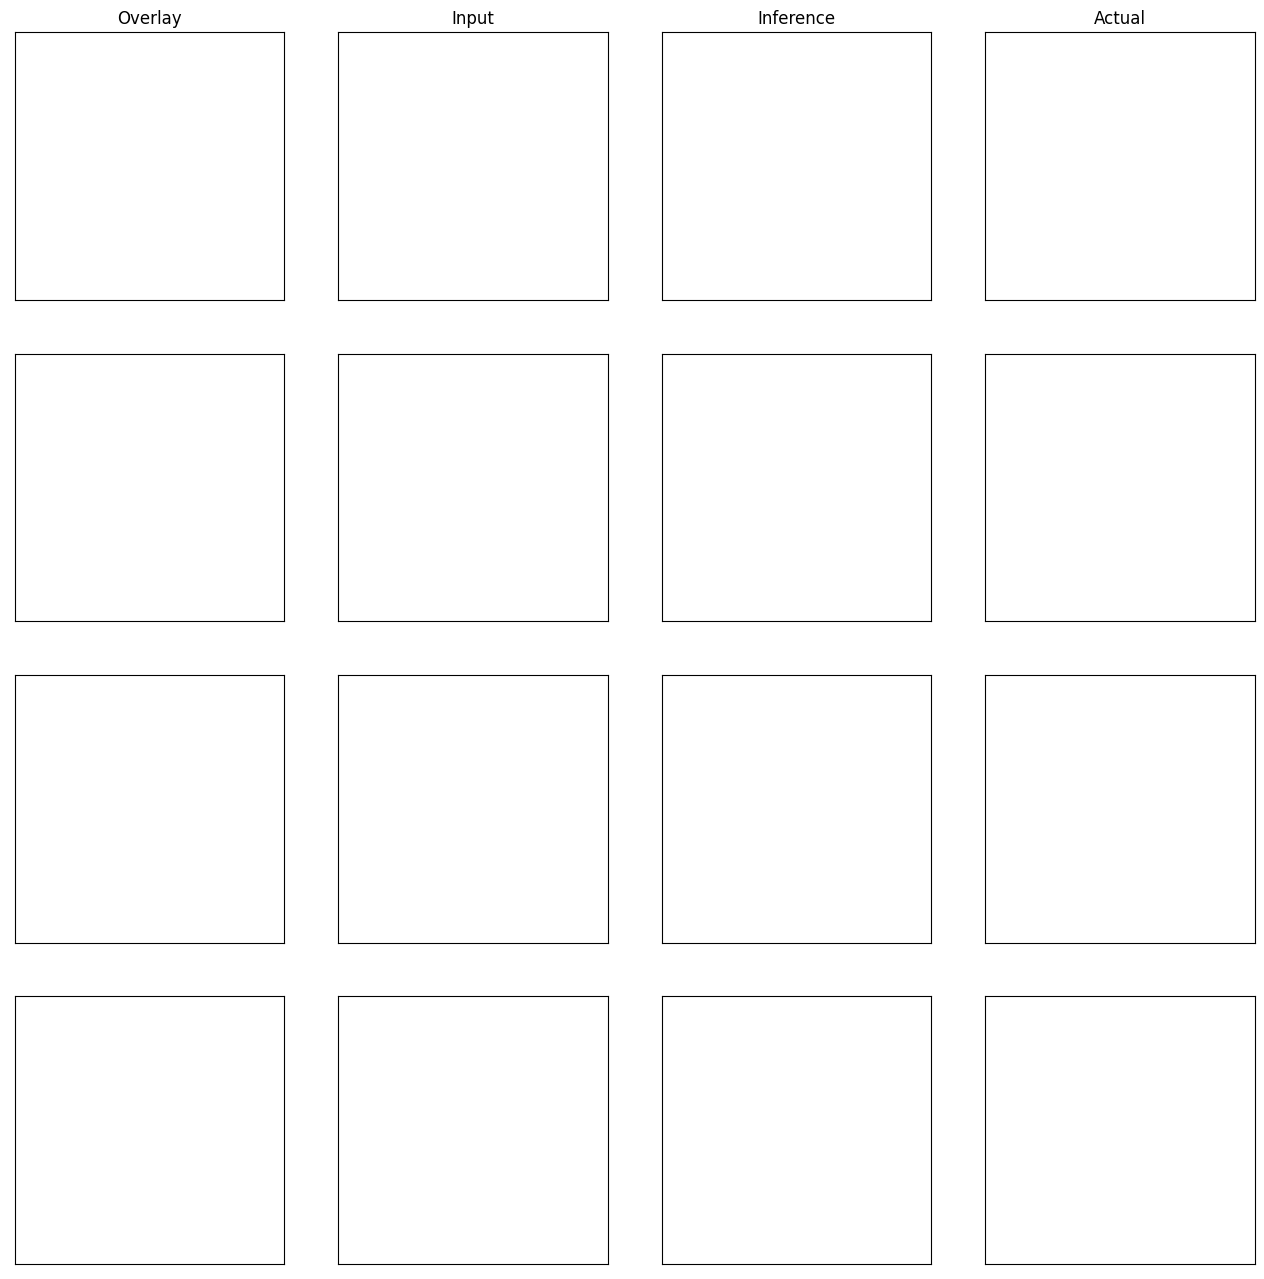

In [22]:
# DO NOT CHANGE THIS CELL
# visualizing random images
NUM_IMAGES = 4

visualize_images(NUM_IMAGES)

<a name='s2-3'></a>
## Model Export ##
Once we are satisfied with our model, we can move to deployment. `unet` includes an `export` subtask to export and prepare a trained U-Net model for deployment. Exporting the model decouples the training process from deployment and allows conversion to TensorRT engines outside the TAO environment. TensorRT is a highly optimized package that takes trained models and optimizes them for inference. TensorRT engines are specific to each hardware configuration and should be generated for each unique inference environment. This may be interchangeably referred to as the `.trt` or `.engine` file. The same exported TAO model may be used universally across training and deployment hardware. This is referred to as the `.etlt` file, or encrypted TAO file. 

<a name='s2-3.1'></a>
### TensorRT - Programmable Inference Accelerator

NVIDIA [TensorRT](https://developer.nvidia.com/tensorrt) is a platform for high-performance deep learning inference. It includes a deep learning inference optimizer and runtime that delivers low latency and high throughput for deep learning inference applications. TensorRT-based applications perform up to 40x faster than CPU-only platforms during inference. 

With TensorRT, we can optimize neural network models trained in all major frameworks, calibrate for lower precision with high accuracy, and finally deploy to hyperscale data centers, embedded, or automotive product platforms.

How TensorRT enables optimizations on the layer graph: 
* Elimination of layers whose outputs are not used
* Fusion of convolution, bias, and ReLU operations
* Aggregation of operations with sufficiently similar parameters and the same source tensor (for example, the 1x1 convolutions in GoogleNet’ s inception module)
* Merging of concatenation layers by directing layer outputs to the correct eventual destination

Here are some great resources to learn more about TensorRT:
 
* Main Page: https://developer.nvidia.com/tensorrt
* Blogs: https://devblogs.nvidia.com/speed-up-inference-tensorrt/
* Download: https://developer.nvidia.com/nvidia-tensorrt-download
* Documentation: https://docs.nvidia.com/deeplearning/sdk/tensorrt-developer-guide/index.html
* Sample Code: https://docs.nvidia.com/deeplearning/sdk/tensorrt-sample-support-guide/index.html
* GitHub: https://github.com/NVIDIA/TensorRT
* NGC Container: https://ngc.nvidia.com/catalog/containers/nvidia:tensorrt

<a name='s2-3.2'></a>
### Export the Trained Model ###
When using the `export` subtask, the `-m` argument indicates the path to the `.tlt` model file to be exported, the `-e` argument indicates the path to the spec file, and `-k` argument indicates the key to _load_ the model. There are two optional arguments, `--gen_ds_config` and `--engine_file` that are useful for us. The `--gen_ds_config` argument indicates whether to generate a template inference configuration file as well as a label file. The `--engine_file` indicates the path to the serialized TensorRT engine file. 
<p><img src='images/important.png' width=720></p>

Note that the TensorRT file is hardware specific and cannot be generalized across GPUs. Since a TensorRT engine file is hardware specific, you cannot use an engine file for deployment unless the deployment GPU is identical to the training GPU. This is true in our case since the Triton Inference Server will run on the same hardware. 

In [ ]:
# DO NOT CHANGE THIS CELL
# remove any previous exports if exists
!rm $LOCAL_EXPERIMENT_DIR/resnet18/weights/resnet18.etlt

In [ ]:
# DO NOT CHANGE THIS CELL
# export model and TensorRT engine
!tao unet export -m $TAO_EXPERIMENT_DIR/resnet18/weights/resnet18.tlt \
                 -e $TAO_SPECS_DIR/resnet18/combined_config.txt \
                 -k $KEY \
                 --engine_file $TAO_EXPERIMENT_DIR/export/resnet18.engine \
                 --gen_ds_config

**Well Done!** Let's move to the [next notebook](./03_model_deployment_for_inference.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/combined_logo.png" alt="Header" style="width: 400px;"/> </a>